In [1]:
import numpy as np
import sys

if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-contrib-python".split())

import cv2

In [2]:
import glob

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

video = cv2.VideoCapture('questao3_source.avi')
codec = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
fps = 30
res = (1280, 720)

wid, hei = 9, 6
n = 0

# Obtendo os corners de cada frame, obtendo seus parametros intrisecos e extrinsecos
# e retirando a distorção dos frames com a marcação dos seus corners.

print('Started analyzing the frames...')

while(video.isOpened()):
    
    ret, img = video.read() 
    if ret: 

        # img = cv2.resize(img,(int(img.shape[1]),int(img.shape[0])))
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        objp = np.zeros((wid*hei, 3), np.float32)
        objp[:,:2] = np.mgrid[0:wid, 0:hei].T.reshape(-1, 2)
        objpoints = [] # real points
        imgpoints = [] # image points

        ret, corners = cv2.findChessboardCorners(img_gray, (wid, hei), None)

        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(img_gray,corners,(5,5),(-1,-1),criteria)
            imgpoints.append(corners2)

            img = cv2.drawChessboardCorners(img, (wid,hei), corners2, ret)

            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_gray.shape[::-1], None, None)
            
            h,  w = img.shape[:2]
            newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))


            dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
            x,y,w,h = roi
            dst = dst[y:y+h, x:x+w]
 
            n = n + 1
        
        # showing the results image by image
        # cv2.imshow('Img', img)
        # video_write.write(img) # generating the output video
   
        if cv2.waitKey(25) & 0xFF == ord('q'): 
            break
   
    else:  
        break

print('Saving camera params from vid')

focal_length = 4.6 # from calibration via images

video.release()



Started analyzing the frames...
Saving camera params from vid


In [3]:
cam_params = {'mtx': np.array(mtx, dtype=np.float32), 'distCoef': np.array(dist, dtype=np.float32)}


In [4]:
cam_params['mtx']

array([[821.2799 ,   0.     , 594.39087],
       [  0.     , 820.1018 , 360.30698],
       [  0.     ,   0.     ,   1.     ]], dtype=float32)

In [12]:
from matplotlib import pyplot as plt

img1_path = "reconstruct_this\\left24.jpg"
img2_path = "reconstruct_this\\right24.jpg"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

img1f = np.array(cv2.imread(img1_path), dtype=np.float32)
img2f = np.array(cv2.imread(img2_path), dtype=np.float32)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)




In [13]:
img1.shape

(4000, 2250, 3)

In [52]:
sift = cv2.SIFT_create(10000)

kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


In [53]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

fundamental, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [54]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

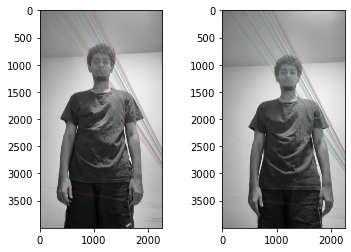

In [55]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, fundamental)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1_gray,img2_gray,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, fundamental)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2_gray,img1_gray,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Disparity Map

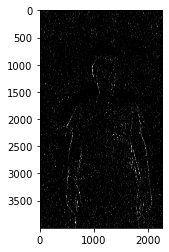

In [56]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img1_gray, img2_gray)
plt.imshow(disparity, 'gray')
plt.show()

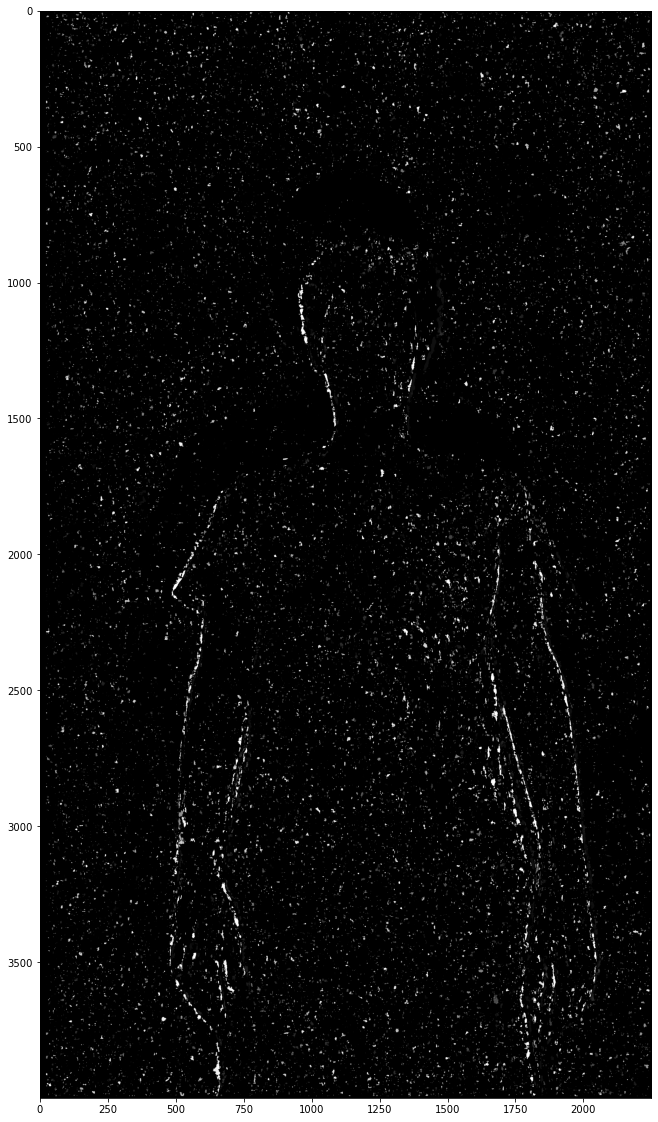

In [57]:
f, axis = plt.subplots(1,1, figsize=(20,20))
axis.imshow(disparity, 'gray')

In [58]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [59]:
def disparityCalc(nDisp=16, blocksize=15):
    stereo = cv2.StereoBM_create(numDisparities=nDisp, blockSize=blocksize)
    disparity = stereo.compute(img1_gray, img2_gray)
    plt.imshow(disparity, 'gray')
    plt.show()
    return disparity

In [60]:
disparityDisplay = interactive(disparityCalc, nDisp=widgets.IntSlider(min=16, max=160, step=16, value=16,), blocksize=widgets.IntSlider(min=5, max=15, step=2, value=5))
disparityDisplay

interactive(children=(IntSlider(value=16, description='nDisp', max=160, min=16, step=16), IntSlider(value=5, d…

In [61]:
disparityDisplay.kwargs

{'nDisp': 48, 'blocksize': 7}

In [62]:
disparityDisplay.result

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)